# Model comparison to GLODAP along GO-SHIP Easy Ocean lines
This notebook shows a means of comparing MOM6 ocean model data to GLODAP data along the WOCE/GO-SHIP sections. GLODAP data are taken from the cruises used to construct the Easy Ocean lines. Model data are interpolated onto the cruis station locations using `xesmf`. See [here](https://www.glodap.info/) for information on GLODAP, and [here](https://cchdo.ucsd.edu/products/goship-easyocean) for information on the Easy Ocean lines.

In [1]:
import pandas as pd
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean
import gsw

In [97]:
from geopy import distance


In [98]:
import xesmf as xe
import sectionate

In [99]:
plotsdir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/figures/" + x
def GLODAPP_LON_to_CM4X(lons):
    lons_copy = 1 * lons 
    lons_copy[lons_copy > 60] -= 360
    return lons_copy
def CM4X_LON_to_GLODAPP(lons): 
    lons_copy = 1 * lons 
    lons_copy[(lons_copy > -300) * (lons_copy < -180)] +=360
    return lons_copy

def CM4X_to_reg_grid(ds): 
    xhcopy = 1 * ds.xh.values
    xhcopy[(ds.xh > -300) * (ds.xh < -180)] += 360
    
    ds_copy = 1 * ds
    ds_copy.coords['xh'] = 1 * xhcopy

    return ds_copy.reindex({ "xh" : xhcopy})

def read_CM4X(fname): 
    return xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":-1, "longitude":-1},
        engine="zarr")

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

In [100]:
new_z_grid = -1 * np.concatenate((np.linspace(0.1, 3000, 30), np.linspace(3025, 4000, 41), np.linspace(4000, 6000, 4)))

In [101]:
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

def interpolate_values(ds, ds_z):
    unique_z, inds = np.unique(ds_z.values, return_index = True)
    ds_subset = ds.values[inds]
    where_nonan = (~np.isnan(unique_z)) + (~np.isnan(ds_subset))
    if len(ds_subset[where_nonan]) > 1:
        interp = interp1d(unique_z[where_nonan], ds_subset[where_nonan], 
                          bounds_error = False, kind = "cubic", fill_value=np.nan)
        return interp(new_z_grid)
    else:
        return np.nan * new_z_grid
    
def interpolate_values_spline(ds, ds_z):
    unique_z, inds = np.unique(ds_z.values, return_index = True)
    ds_subset = ds.values[inds]
    where_nonan = (~np.isnan(unique_z)) * (~np.isnan(ds_subset))
    if len(ds_subset[where_nonan]) > 1:
        interp = CubicSpline(unique_z[where_nonan], ds_subset[where_nonan], extrapolate = False, bc_type = "natural")
        return interp(new_z_grid)
    else:
        return np.nan * new_z_grid
    
def interpolate_section(ds):
    ds_z = 1 * ds.z
    new_ds = 1 * ds.drop("z")
    new_ds.coords['zl'] = 1 * new_z_grid

    for key,value in new_ds.items():
        print(key)
        for i in range(len(ds.distance)):
            tmp = interpolate_values_spline(new_ds[key].isel(distance = i), ds_z.isel(distance = i))
            new_ds[key].values[:, i] = tmp
            
    return new_ds

def interpolate_section_ds(ds):
    ds_z = 1 * ds.z
    new_ds = 1 * ds.drop("z")
    new_ds.coords['zl'] = 1 * new_z_grid

    for key,value in new_ds.items():
        print(key)
        for i in range(len(ds.xh)):
            tmp = interpolate_values_spline(new_ds[key].isel(xh = i), ds_z.isel(xh = i))
            new_ds[key].values[:, i] = tmp
            
    return new_ds

## Read GLODAP data

In [102]:
def get_sigma2(ds, keep_vars = False): 
    ds['p'] = xr.apply_ufunc(
        gsw.p_from_z, ds.z, ds.lat, 0, 0, dask="parallelized"
    )


    ds['sa'] = xr.apply_ufunc(
        gsw.SA_from_SP,
        ds.so,
        ds.p,
        ds.lon,
        ds.lat,
        dask="parallelized",
    )
    ds['ct'] = xr.apply_ufunc(
        gsw.CT_from_t,
        ds.sa,
        ds.thetao,
        ds.p,
        dask="parallelized"
    )

    ds['sigma2'] = xr.apply_ufunc(
        gsw.sigma2,
        ds.sa,
        ds.ct,
        dask="parallelized"
    )
    if keep_vars: 
        return ds
    else: 
        return ds.drop_vars(["p", "sa", "ct"])

In [103]:
df = pd.read_csv('GLODAPv2.2023_Merged_Master_File.csv',na_values=9999)

/tmp/ipykernel_215808/3962376062.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('GLODAPv2.2023_Merged_Master_File.csv',na_values=9999)


In [104]:
df = df.replace(-9999, np.nan)

## Plot options
Specify a WOCE/GO-SHIP section line to look at, and a year range for the model.

In [149]:
line = 'I09S'
time = '2007-2020'

In [150]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmolkg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmolkg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'PuRd','units':'fmolkg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

## Read GO-SHIP Easy Ocean data

In [151]:
rootdir = glob.glob('GO-SHIP/gridded/*/'+line)[0]
# Get merged netcdf file
filename = line.lower()+'.nc'
path = '/'.join([rootdir,filename])
dso_nc = xr.open_dataset(path)

## Match GLODAP data with cruises used for Easy Ocean
(via the `expocode`)

In [152]:
# Get the relevant expocode
# NOTE This approach assumes that the all_years_used
# and the expocode attributes of the netcdf file have 
# the same number of entries listed, and that they are
# aligned in the same order
# I can probably implement some checks for this
years = re.findall(r'\d+', dso_nc.attrs['all_years_used'])
ecs = dso_nc.attrs['expocode'].split(',')

In [153]:
ecs_i = list(set(ecs) & set(list(df['G2expocode'].unique())))
print('Available cruise data : '+' '.join(ecs_i))

Available cruise data : 09AR20041223 09AR20120105


In [154]:
# Subset GLODAP data for available cruise
cond = df['G2expocode']==''
for ec in ecs:
    cond += (df['G2expocode']==ec)
dfo_all = df[cond]

In [155]:
# Find cruises that fall within model averaging period
year_bnds = [int(a) for a in (time.split("-"))]
leeway = 1
cond = dfo_all['G2year']==''
for year in dfo_all['G2year'].unique():
    if year_bnds[0]-leeway <= year <= year_bnds[1]+leeway:
        cond += (dfo_all['G2year']==year)
dfo = dfo_all[cond]
if len(dfo)==0:
    yearstr = [str(e) for e in dfo_all['G2year'].unique()]
    raise Exception('No suitable GLODAP data for selected WOCE line and year\n'+
                   'Avaliable data: '+' '.join(ecs_i)+'\n'+
                   'For years: '+' '.join(yearstr))

## Derive sections for each cruise, and corresponding model data

In [156]:
def calc_dz(depth):
    d1 = depth.copy()
    zeros = xr.zeros_like(d1.isel(n=0)).expand_dims({'ni':[0]})
    ids = 0.5*(d1+d1.shift(n=-1)).rename({'n':'ni'}).assign_coords({'ni':d1['n'].values+1})
    idepth = xr.concat([zeros,ids],dim='ni')
    dz = idepth.diff('ni')
    dz.loc[{'ni':len(dz['ni'])}]=dz.isel(ni=-2)
    dz = dz.rename({'ni':'n'}).assign_coords({'n':d1['n']})
    return dz

def calc_dz_1d(depth):
    ids = 0.5*(depth[1:]+depth[:-1])
    idepth = np.append(np.array([0]),ids)
    dz = np.diff(idepth)
    dz = np.append(dz,dz[-1])
    return dz
    
def calc_dx(distance):
    d1 = distance.values
    mid = 0.5*(d1[1:]+d1[:-1])
    mid = np.append(-mid[0],mid)
    dx = np.diff(mid)
    dx = np.append(dx,dx[-1])
    return xr.DataArray(dx,dims=distance.dims,coords=distance.coords)

In [157]:
glodap_variables = ['cfc11','cfc12','sf6','theta','salinity']
sections = {}
cruises = dfo['G2cruise'].unique()
for cruise in cruises:
    dfonow = dfo[dfo['G2cruise']==cruise]
    stations = dfonow['G2station'].unique()
    
    ns = len(stations)
    
    # Find max no. measurements at each station
    # And distance along section
    maxn = 0
    distance = np.zeros(shape=(ns,))
    # avg_time = dfonow["G2year"] + (dfonow["G2month"] / 12)
    avg_time = dfonow["G2year"]

    avg_time = np.nanmean(avg_time.values)
    
    for i,station in enumerate(stations):
        dfostation = dfonow[dfonow['G2station']==station]
        if i==0:
            lonlast = dfostation['G2longitude'].mean()
            latlast = dfostation['G2latitude'].mean()
        else:
            lon = dfostation['G2longitude'].mean()
            lat = dfostation['G2latitude'].mean()
            distance[i]=geopy.distance.distance((lat,lon),(latlast,lonlast)).km
        if len(dfostation)>maxn:
            maxn = len(dfostation)
    
    nb = maxn
    
    # Populate numpy arrays
    lons = np.full(shape=(ns,),fill_value=np.nan)
    lats = np.full(shape=(ns,),fill_value=np.nan)
    depths = np.full(shape=(ns,nb),fill_value=np.nan)
    dzs = np.full(shape=(ns,nb),fill_value=np.nan)
    variables = {}
    for gv in glodap_variables:
        variables[gv]=np.full(shape=(ns,nb),fill_value=np.nan)
    for i,station in enumerate(stations):
        dfostation = dfonow[dfonow['G2station']==station]
        n = len(dfostation)
        
        lon = dfostation['G2longitude'].mean()
        lat = dfostation['G2latitude'].mean()
        depth = dfostation['G2depth']
        lons[i,]=lon
        lats[i,]=lat
        depths[i,:n]=depth
        dzs[i,:n] = calc_dz_1d(depth.values)
        
        for variable in variables.keys():
            tmp = dfostation['G2'+variable]
            # Get the variable at unique depths by creating a dictionary
            dt = dict(zip(depth,tmp))
            # Recreate variable at all depths
            tmpnow = [dt[d] for d in depth]
            variables[variable][i,:n] = tmpnow
        
    # Assign to dataset
    section = xr.Dataset({
        'lon':xr.DataArray(GLODAPP_LON_to_CM4X(lons),dims=('distance'),coords={'distance':np.cumsum(distance)}),
        'lat':xr.DataArray(lats,dims=('distance'),coords={'distance':np.cumsum(distance)}),
        'depth':xr.DataArray(depths,dims=('distance','n'),coords={'distance':np.cumsum(distance)}),
        'dz':xr.DataArray(dzs,dims=('distance','n'),coords={'distance':np.cumsum(distance)})}
    )
    section["time"] = avg_time
    for variable,array in variables.items():
        section[variable] = xr.DataArray(array,dims=('distance','n'),coords={'distance':np.cumsum(distance)})
        
    # Calculate appropriate "grid variables"
    section['dx'] = calc_dx(section['distance'])
        
    sections[cruise]=section

## Plot section locations

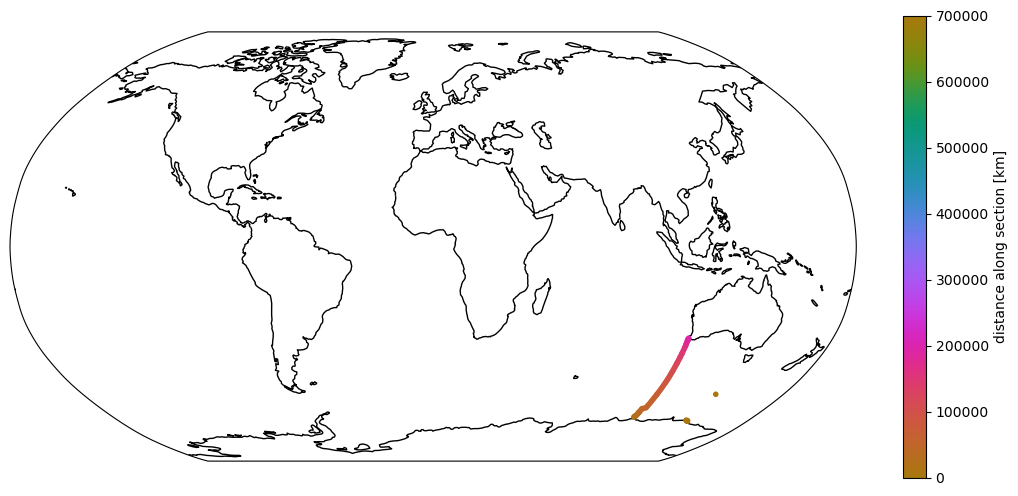

In [158]:
import matplotlib.ticker as ticker

def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)


fig,ax=plt.subplots(figsize=(12,6),subplot_kw={'projection':ccrs.Robinson(central_longitude = 0)})
ax.set_global()
ax.coastlines()
for cruise,section in sections.items():
    x = CM4X_LON_to_GLODAPP(section['lon'])
    y = section['lat']
    l = ax.scatter(x,y,transform=ccrs.PlateCarree(),marker='.', c = section.distance.values,cmap=cmocean.cm.phase,zorder=10, vmin = 0, vmax = 700000)
    cbar = fig.colorbar(l, orientation = "vertical", fraction = 0.04, label = "distance along section [km]")
    # cbar.ax.tick_params(rotation=0)

    # # color = l[0].get_color()
    # ax.text(x[int(len(x)/2)]+10,y[int(len(y)/2)],str(cruise),transform=ccrs.PlateCarree(),color=color,fontweight='bold',horizontalalignment='left')
    # ax.text(x[0]+5,y[0],'start',transform=ccrs.PlateCarree(),color=color,horizontalalignment='left')
    # ax.text(x[-1]+5,y[-1],'end',transform=ccrs.PlateCarree(),color=color,horizontalalignment='left')

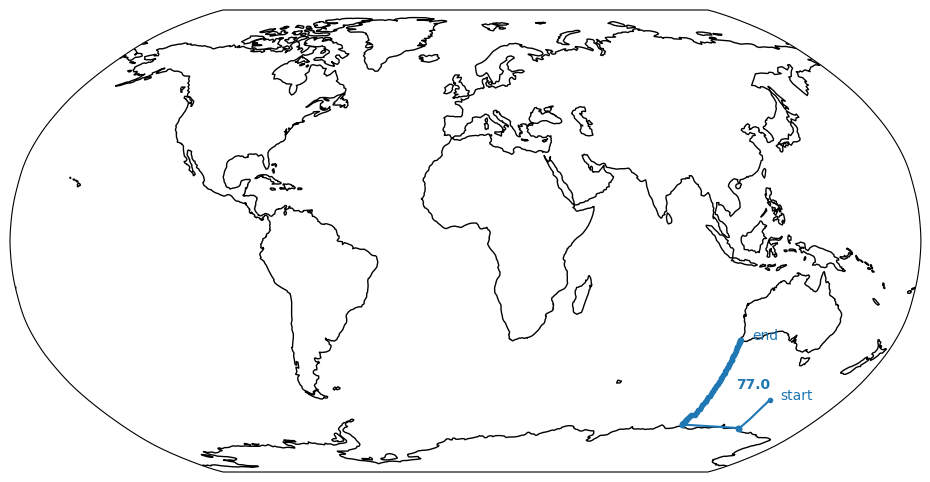

In [159]:
fig,ax=plt.subplots(figsize=(12,6),subplot_kw={'projection':ccrs.Robinson(central_longitude = 0)})
ax.set_global()
ax.coastlines()
for cruise,section in sections.items():
    x = CM4X_LON_to_GLODAPP(section['lon'])
    y = section['lat']
    l = ax.plot(x,y,transform=ccrs.PlateCarree(),marker='.')
    
    color = l[0].get_color()
    ax.text(x[int(len(x)/2)]+10,y[int(len(y)/2)],str(cruise),transform=ccrs.PlateCarree(),color=color,fontweight='bold',horizontalalignment='left')
    ax.text(x[0]+5,y[0],'start',transform=ccrs.PlateCarree(),color=color,horizontalalignment='left')
    ax.text(x[-1]+5,y[-1],'end',transform=ccrs.PlateCarree(),color=color,horizontalalignment='left')

In [160]:
cruise_times = np.array([int(s.time.values) for s in sections.values()])
print(cruise_times)

[2012]


In [161]:
ds = read_CM4X("../CM4Xp25_historical_transient_tracers.zarr")
ds = ds.sel(year = slice(cruise_times.min(), cruise_times.max())).mean("year")

ds["z"] = ds["z"].transpose("zl", "yh", "xh")
ds["thkcello"] = ds["thkcello"].transpose("zl", "yh", "xh")

ds = ds.drop(["lat", "lon"])
ds = ds.rename({"geolat":"lat", "geolon":"lon"})
dsm = get_sigma2(ds)

In [162]:
sections_dsm = {}
for cruise, section in sections.items():
    regridder = xe.Regridder(ds, sections[cruise][["lon", "lat"]], "bilinear", locstream_out=True)
    section_dsm = regridder(ds)

    print("Cruise #: ", cruise)

    # Apply conversion
    for key,value in variable_kwargs.items():
        if key in section_dsm.keys():
            print(key)
            section_dsm[key] = section_dsm[key]*variable_kwargs[key]['conversion']
    # section_dsm = section_dsm.where(section_dsm.thkcello > 1e-10)
    sections_dsm[cruise] = 1 * section_dsm

Cruise #:  77.0
cfc12
cfc11
sf6


In [163]:
sections_dsmo = {}
for cruise,section_dsm in sections_dsm.items():
    # section_dsmo = section_dsm.drop(['zl'])
    # section_dsmo['depth']=section['depth']
    sections_dsmo[cruise] = 1 * interpolate_section(sections_dsm[cruise].compute())

cfc11
cfc12
sf6
so
thetao
thkcello
p
sa
ct
sigma2


## Independent check of 105 interpolation

In [164]:
# independent_P16 = ds.sel(yh = sections[20.0].lat.mean(), method = "nearest").compute()
# independent_P16 = independent_P16.sel(xh = slice(sections[20.0].lon.min() - 20, sections[355.0].lon.max()))
# independent_P16 = interpolate_section_ds(independent_P16)

## Plot sections of temperature

Text(0.5, 0.98, 'CM4X Output')

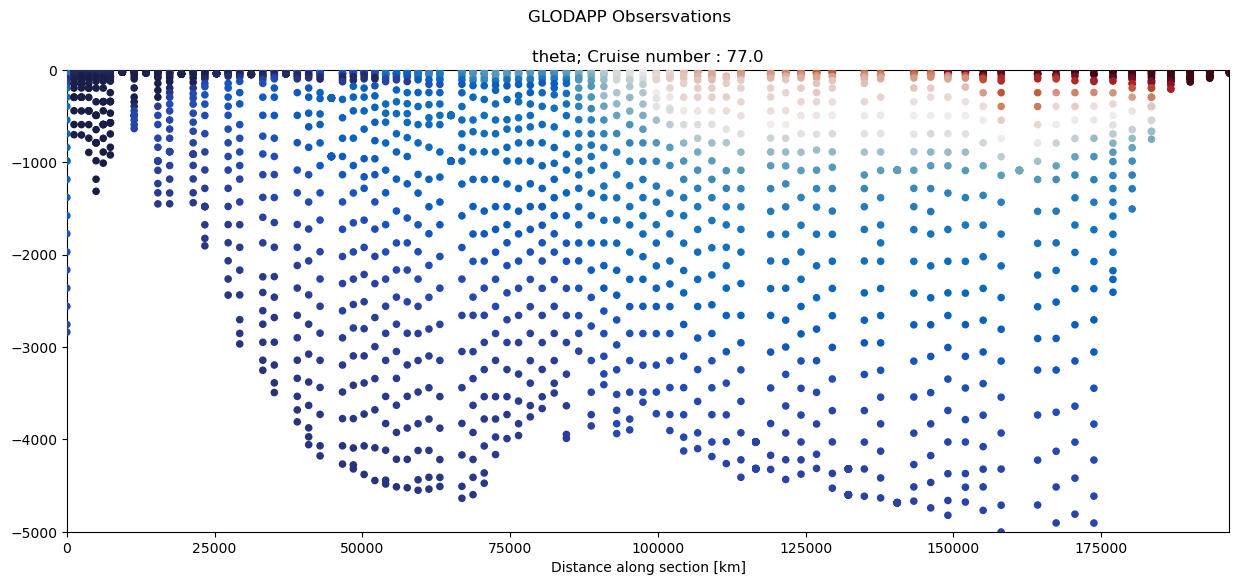

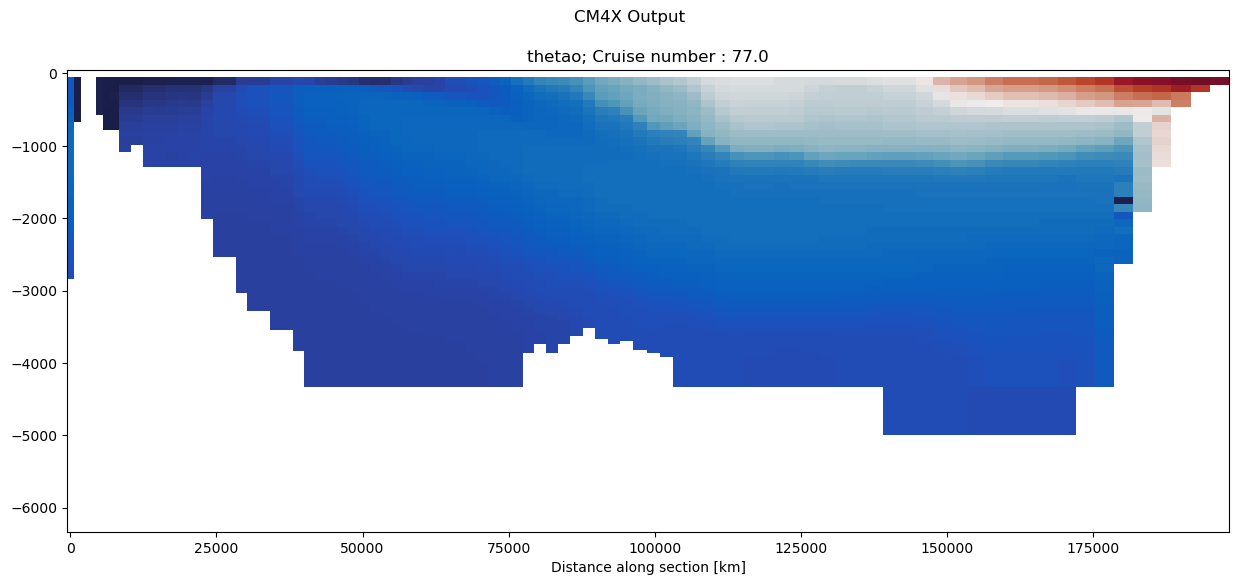

In [165]:
variable = 'theta'
cmap = cmocean.cm.balance
units = "°C"
fig,axes = plt.subplots(1, 1, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes
    X, _ = np.meshgrid(sections[cruise].distance, sections[cruise].n)
    Z = sections[cruise][variable].values
    Z[np.abs(Z) > 100] = np.nan
    Y = 1 * sections[cruise].depth.values; Y[np.isnan(Y)] = 10
    im2 = ax.scatter(X.T.flatten(), -Y.flatten(),c = Z.flatten() ,s=20, cmap=cmap,zorder=10, vmin = -2, vmax = 20)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise))
    ax.set_ylim(-5000, 0)
    ax.set_xlim(sections[cruise].distance.min(), sections[cruise].distance.max())

fig.subplots_adjust(wspace = 0.05)
fig.suptitle("GLODAPP Obsersvations")

variable = 'thetao'
cmap = cmocean.cm.balance
units = "°C"
fig,axes = plt.subplots(1, 1, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes
    Z = sections_dsmo[cruise][variable].values
    # Z[Z == 0.0] = np.nan
    im = ax.pcolormesh(sections_dsmo[cruise].distance,sections_dsmo[cruise].zl, Z, cmap=cmap, vmin = -2, vmax = 20)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise))
    
fig.subplots_adjust(wspace = 0.05)
fig.suptitle("CM4X Output")

/tmp/ipykernel_215808/542156911.py:30: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = -4, vmax = 10)


Text(0.5, 0.98, 'CM4X Output')

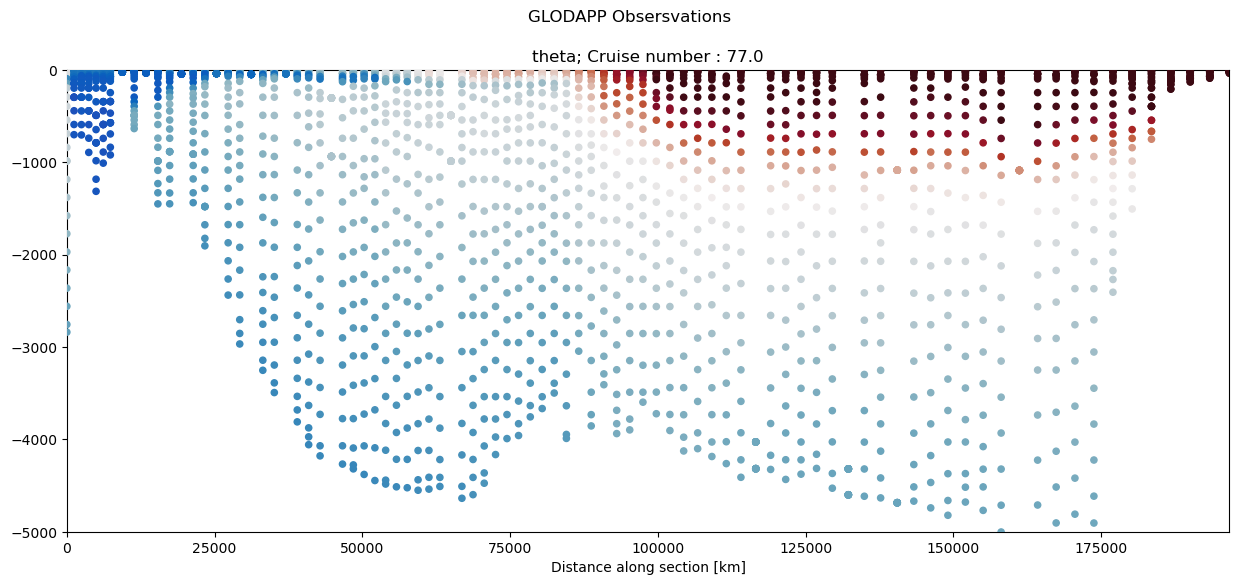

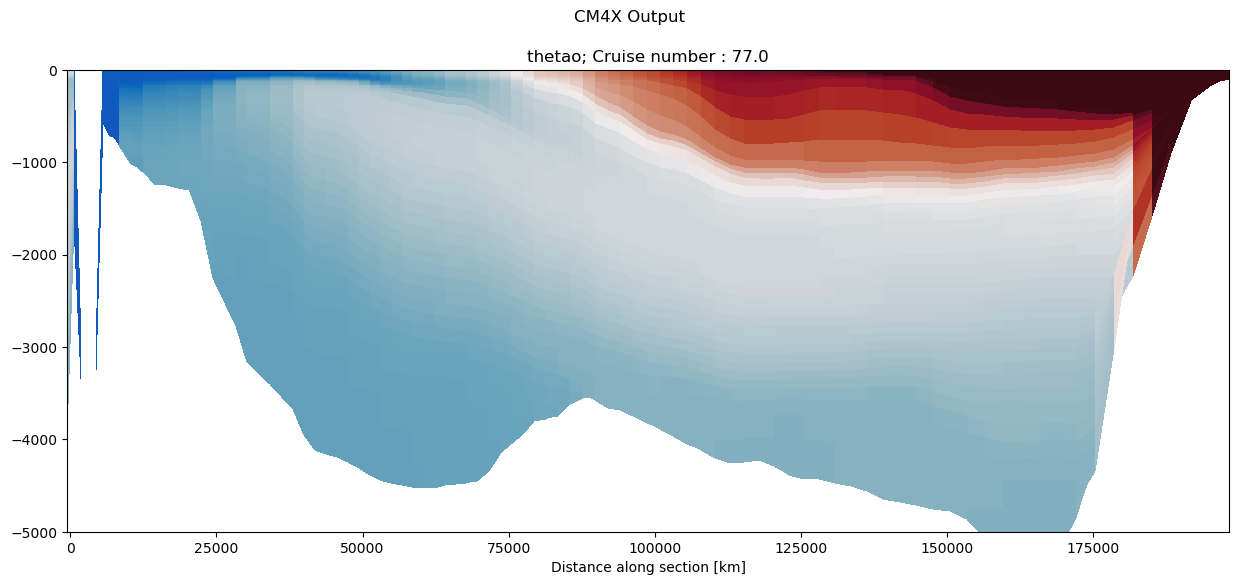

In [166]:
variable = 'theta'
cmap = cmocean.cm.balance
units = "°C"
fig,axes = plt.subplots(1, 1, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes
    X, _ = np.meshgrid(sections[cruise].distance, sections[cruise].n)
    Z = sections[cruise][variable].values
    Z[np.abs(Z) > 100] = np.nan
    Y = 1 * sections[cruise].depth.values; Y[np.isnan(Y)] = 10
    im2 = ax.scatter(X.T.flatten(), -Y.flatten(),c = Z.flatten() ,s=20, cmap=cmap,zorder=10, vmin = -4, vmax = 10)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise))
    ax.set_ylim(-5000, 0)
    ax.set_xlim(sections[cruise].distance.min(), sections[cruise].distance.max())

fig.subplots_adjust(wspace = 0.05)
fig.suptitle("GLODAPP Obsersvations")

variable = 'thetao'
cmap = cmocean.cm.balance
units = "°C"
fig,axes = plt.subplots(1, 1, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes
    X, _ = np.meshgrid(sections_dsm[cruise].distance, sections_dsm[cruise].zl)
    Z = sections_dsm[cruise][variable].values
    Y = 1 * sections_dsm[cruise].z.values; Y[np.isnan(Y)] = -6000
    Z[Z == 0.0] = np.nan
    im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = -4, vmax = 10)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise))
    ax.set_ylim(-5000, 0)
fig.subplots_adjust(wspace = 0.05)
fig.suptitle("CM4X Output")

In [167]:
levels = np.linspace(30, 45, 90)

Text(0.5, 0.98, 'CM4X Output')

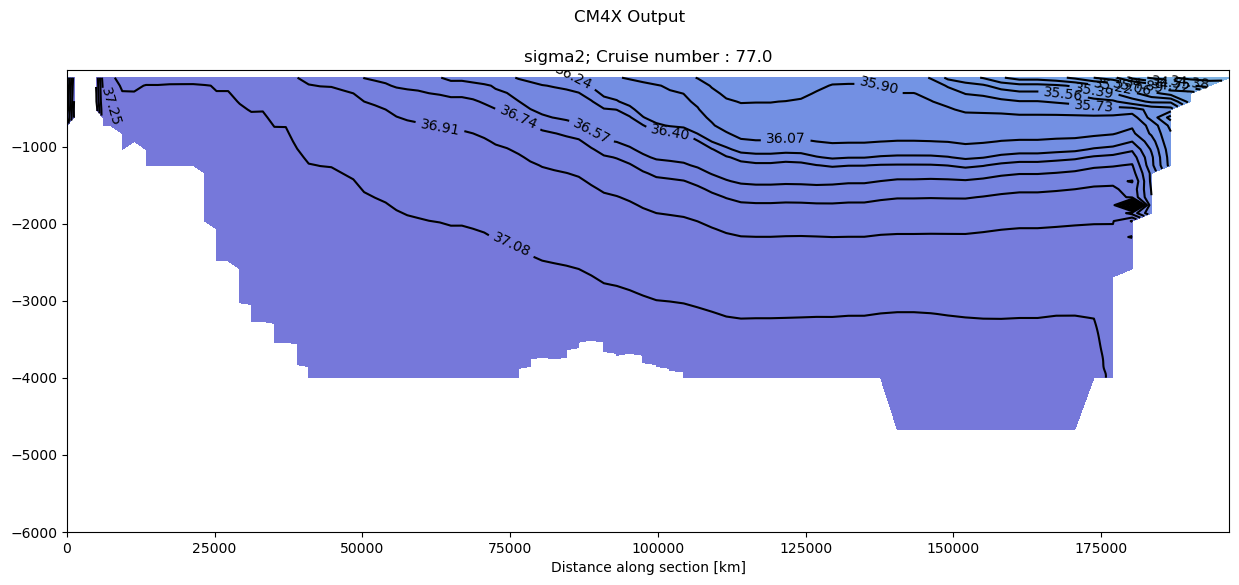

In [168]:
variable = 'sigma2'
cmap = cmocean.cm.balance
units = "°C"
# fig,axes = plt.subplots(1, 1, figsize=(15,6), sharey = True)
# for (i, cruise) in enumerate(sections.keys()):
#     ax = axes
#     X, _ = np.meshgrid(sections[cruise].distance, sections[cruise].n)
#     Z = sections[cruise][variable].values
#     Z[np.abs(Z) > 100] = np.nan
#     Y = 1 * sections[cruise].depth.values; Y[np.isnan(Y)] = 10
#     im2 = ax.scatter(X.T.flatten(), -Y.flatten(),c = Z.flatten() ,s=20, cmap=cmap,zorder=10, vmin = -2, vmax = 20)
#     ax.set_xlabel('Distance along section [km]')
#     ax.set_title(variable+'; Cruise number : '+str(cruise))
#     ax.set_ylim(-5000, 0)
#     ax.set_xlim(sections[cruise].distance.min(), sections[cruise].distance.max())

# fig.subplots_adjust(wspace = 0.05)
# fig.suptitle("GLODAPP Obsersvations")

variable = 'sigma2'
cmap = cmocean.cm.dense
units = "°C"
fig,axes = plt.subplots(1, 1, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes
    Z = sections_dsmo[cruise][variable].values
    # Z[Z == 0.0] = np.nan
    im = ax.contourf(sections_dsmo[cruise].distance,sections_dsmo[cruise].zl, Z, cmap=cmap, vmin = 30, vmax = 45, levels = levels, extend = "both")
    im = ax.contour(sections_dsmo[cruise].distance,sections_dsmo[cruise].zl, Z, colors="k", vmin = 30, vmax = 45, levels = levels)
    ax.clabel(im)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise))
    
fig.subplots_adjust(wspace = 0.05)
fig.suptitle("CM4X Output")

## Plot sections of CFC12

In [169]:
Z.flatten()

array([nan, nan, nan, ..., nan, nan, nan])

StopIteration: 

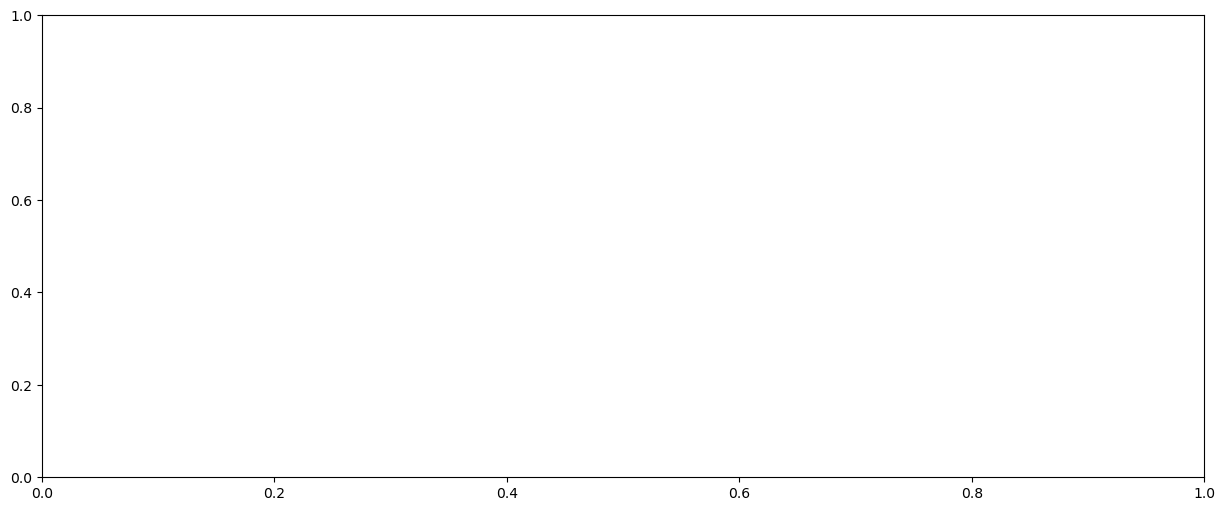

In [170]:
variable = 'cfc12'
cmap = variable_kwargs[variable]['cmap']
units = variable_kwargs[variable]['units']
fig,axes = plt.subplots(1, 1, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes
    X, _ = np.meshgrid(sections[cruise].distance, sections[cruise].n)
    Z = sections[cruise][variable].values
    Y = 1 * sections[cruise].depth.values; Y[np.isnan(Y)] = 10
    im2 = ax.scatter(X.T.flatten(), -Y.flatten(),c = Z.flatten() ,s=50, cmap=cmap,zorder=10, vmin = 0, vmax = 0.1)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise))
    ax.set_ylim(-5000, 0)
    ax.set_xlim(sections[cruise].distance.min(), sections[cruise].distance.max())
fig.subplots_adjust(wspace = 0.05)
fig.suptitle("GLODAPP Obsersvations")

variable = 'cfc12'
cmap = variable_kwargs[variable]['cmap']
units = variable_kwargs[variable]['units']
fig,axes = plt.subplots(1, 1, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes
    X, _ = np.meshgrid(sections_dsm[cruise].distance, sections_dsm[cruise].zl)
    Z = sections_dsm[cruise][variable].values
    Y = 1 * sections_dsm[cruise].z.values; Y[np.isnan(Y)] = 10
    im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = 0, vmax = 0.1)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise))
fig.subplots_adjust(wspace = 0.05)
fig.suptitle("CM4X Output")

StopIteration: 

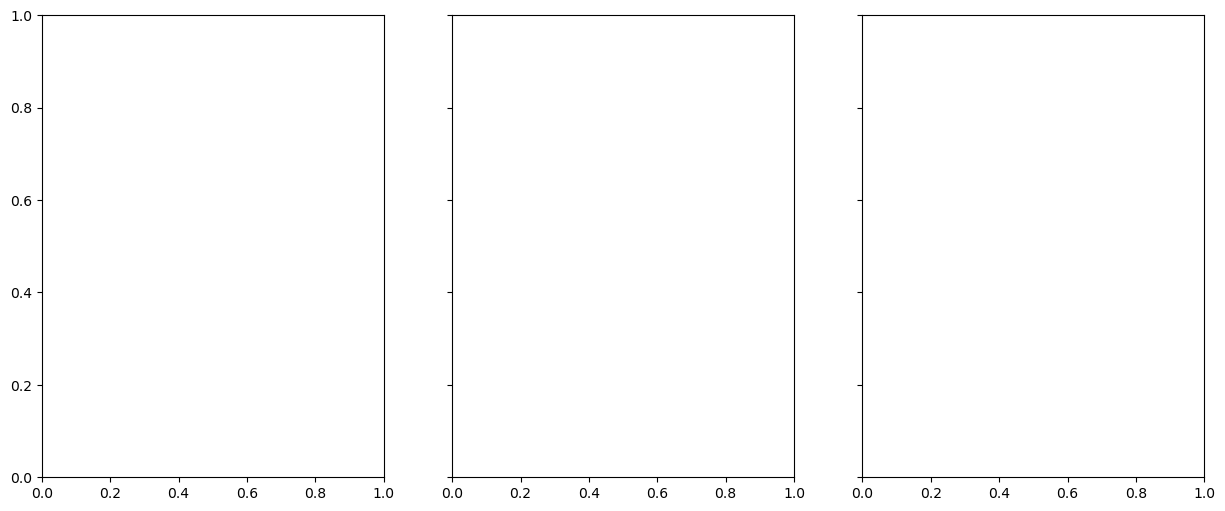

In [171]:
variable = 'cfc11'
cmap = variable_kwargs[variable]['cmap']
units = variable_kwargs[variable]['units']
fig,axes = plt.subplots(1, 3, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    X, _ = np.meshgrid(sections[cruise].distance, sections[cruise].n)
    Z = sections[cruise][variable].values
    Y = 1 * sections[cruise].depth.values; Y[np.isnan(Y)] = 10
    im2 = ax.scatter(X.T.flatten(), -Y.flatten(),c = Z.flatten() ,s=50, cmap=cmap,zorder=10, vmin = 0, vmax = 3)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise))
    ax.set_ylim(-5000, 0)
fig.subplots_adjust(wspace = 0.05)
fig.suptitle("GLODAPP Obsersvations")

fig.savefig(plotsdir("GLODAPP_SR04_CFC12.png"), dpi = 400, bbox_inches = "tight")

variable = 'cfc11'
cmap = variable_kwargs[variable]['cmap']
units = variable_kwargs[variable]['units']
fig,axes = plt.subplots(1, 3, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    X, _ = np.meshgrid(sections_dsm[cruise].distance, sections_dsm[cruise].zl)
    Z = sections_dsm[cruise][variable].values
    Y = 1 * sections_dsm[cruise].z.values; Y[np.isnan(Y)] = 10
    im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = 0, vmax = 3)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise))
fig.subplots_adjust(wspace = 0.05)
fig.suptitle("CM4X Output")

fig.savefig(plotsdir("CM4X_SR04_CFC11.png"), dpi = 400, bbox_inches = "tight")


StopIteration: 

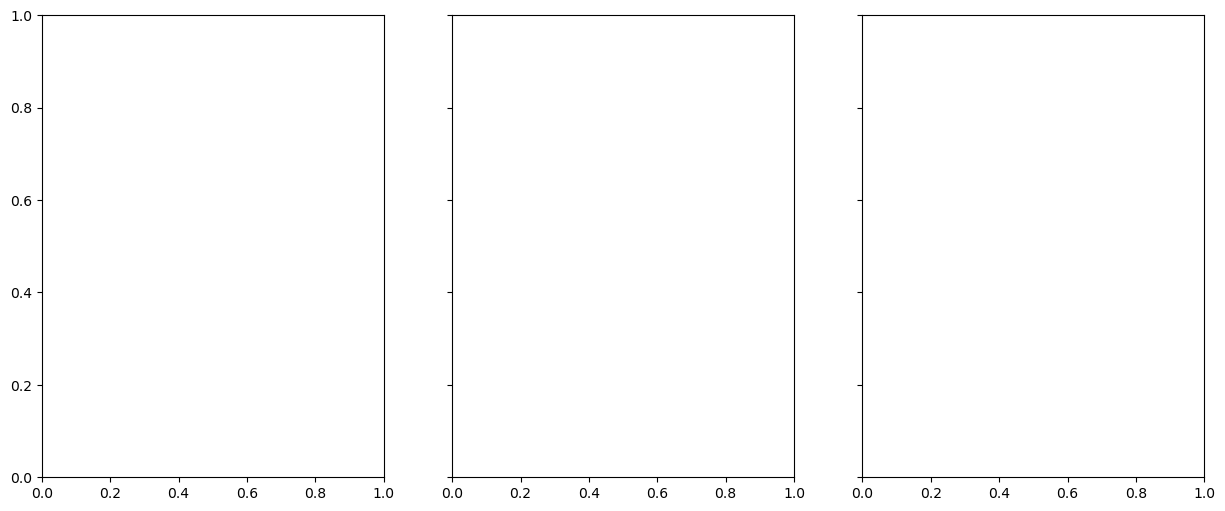

In [172]:
variable = 'sf6'
cmap = variable_kwargs[variable]['cmap']
units = variable_kwargs[variable]['units']
fig,axes = plt.subplots(1, 3, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    X, _ = np.meshgrid(sections[cruise].distance, sections[cruise].n)
    Z = sections[cruise][variable].values
    Y = 1 * sections[cruise].depth.values; Y[np.isnan(Y)] = 10
    im2 = ax.scatter(X.T.flatten(), -Y.flatten(),c = Z.flatten() ,s=50, cmap=cmap,zorder=10, vmin = 0, vmax = 3)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise))
    ax.set_ylim(-5000, 0)
fig.subplots_adjust(wspace = 0.05)
fig.suptitle("GLODAPP Obsersvations")

fig.savefig(plotsdir("GLODAPP_SR04_SF6.png"), dpi = 400, bbox_inches = "tight")

variable = 'sf6'
cmap = variable_kwargs[variable]['cmap']
units = variable_kwargs[variable]['units']
fig,axes = plt.subplots(1, 3, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    X, _ = np.meshgrid(sections_dsm[cruise].distance, sections_dsm[cruise].zl)
    Z = sections_dsm[cruise][variable].values
    Y = 1 * sections_dsm[cruise].z.values; Y[np.isnan(Y)] = 10
    im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = 0, vmax = 3)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise))
fig.subplots_adjust(wspace = 0.05)
fig.suptitle("CM4X Output")

fig.savefig(plotsdir("CM4X_SR04_SF6.png"), dpi = 400, bbox_inches = "tight")


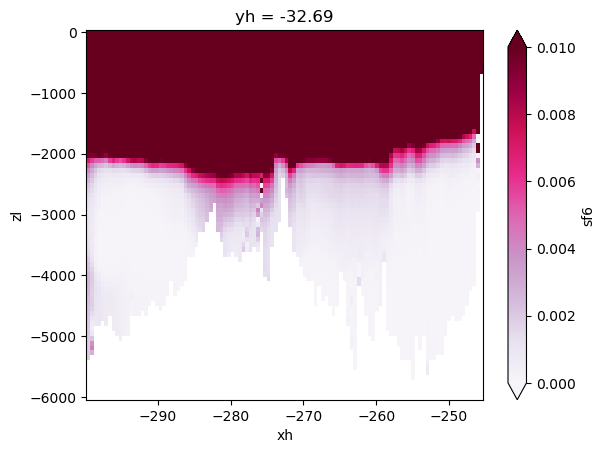

In [115]:
(independent_P16.sf6 * variable_kwargs["sf6"]['conversion']).plot(cmap=cmap, vmin = 0, vmax = 0.01)

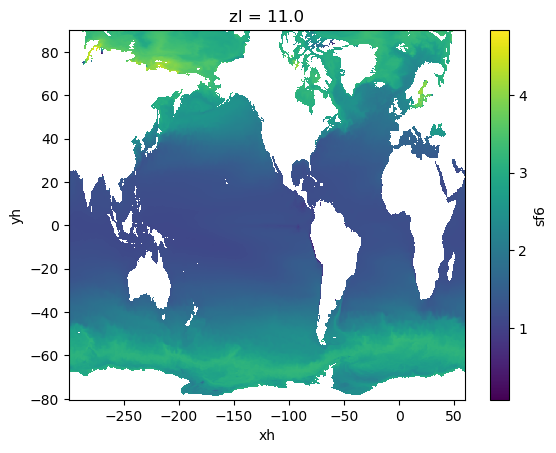

In [345]:
(ds.isel(zl = 5).sf6 * variable_kwargs["sf6"]['conversion']).plot()

### Overlain anomalies

ValueError: 'c' argument has 2700 elements, which is inconsistent with 'x' and 'y' with size 36.

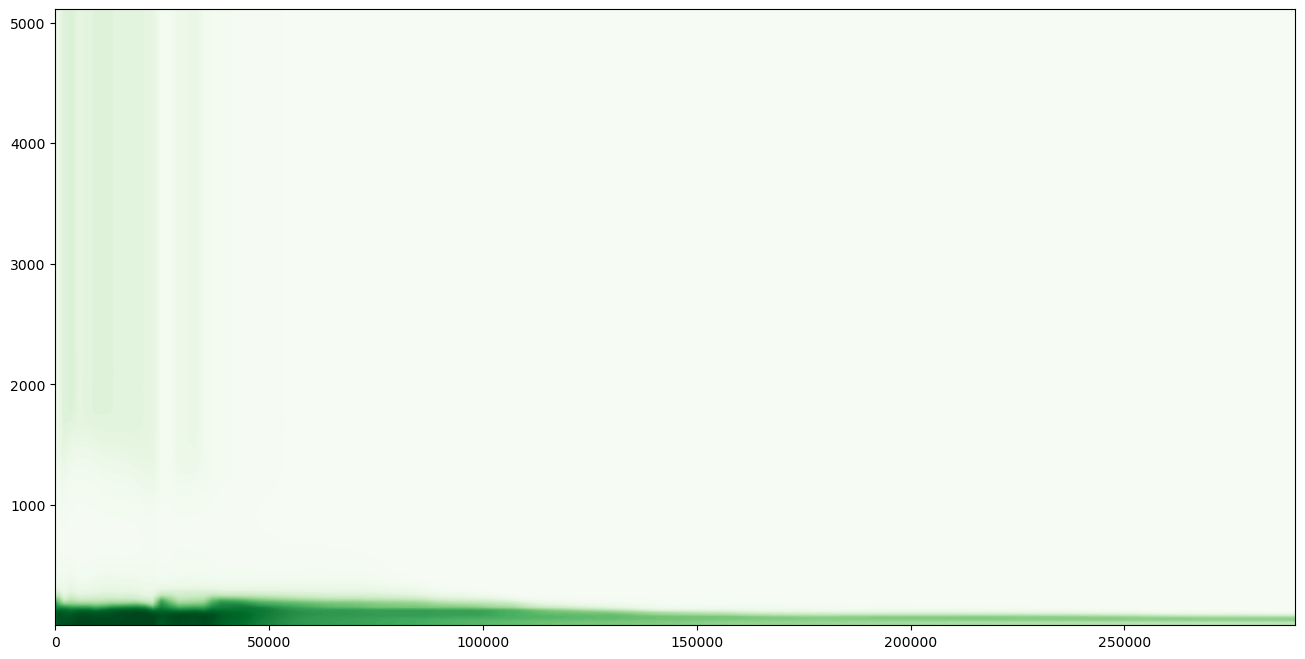

In [48]:
variable = 'cfc12'
cmap = variable_kwargs[variable]['cmap']
units = variable_kwargs[variable]['units']
for cruise in sections.keys():
    dsonow = sections[cruise]
    dsmnow = sections_dsm[cruise]
    dsmonow = sections_dsmo[cruise]
    bias = dsmonow - dsonow
    # Replace depth variable
    bias['depth'] = dsonow['depth']
    fig,ax = plt.subplots(figsize=(16,8))
    im1 = ax.contourf(dsmnow['distance'],dsmnow['zl'],dsmnow[variable],100,cmap=cmap)
    # ax.contour(dsmnow['distance'],dsmnow['z_l'],dsmnow['theta'],14,colors='tab:purple',alpha=0.5)
    # ax.contour(dsmnow['distance'],dsmnow['z_l'],dsmnow['salinity'],14,colors='tab:brown',alpha=0.5)
    im2 = ax.scatter(bias['distance']*xr.ones_like(bias['depth']),bias['depth'],s=15,c=bias[variable],cmap='RdBu_r',zorder=10)
    clims_bias = im2.get_clim()
    cmax = np.max(np.abs(clims_bias))
    im2.set_clim([-1*cmax,cmax])
    ax.set_xlabel('Distance along section [km]')
    ax.set_ylabel('Depth [m]')
    ax.set_ylim([6000,0])
    ax.set_title(variable+'; Cruise number : '+str(cruise))
    # Add colorbars
    axc1 = fig.add_axes([0.92,0.2,0.01,0.6])
    cb = fig.colorbar(im1,axc1,orientation='vertical')
    axc2 = fig.add_axes([0.92+0.06,0.2,0.01,0.6])
    cb = fig.colorbar(im2,axc2,orientation='vertical')
    cb.set_label('['+units+']')

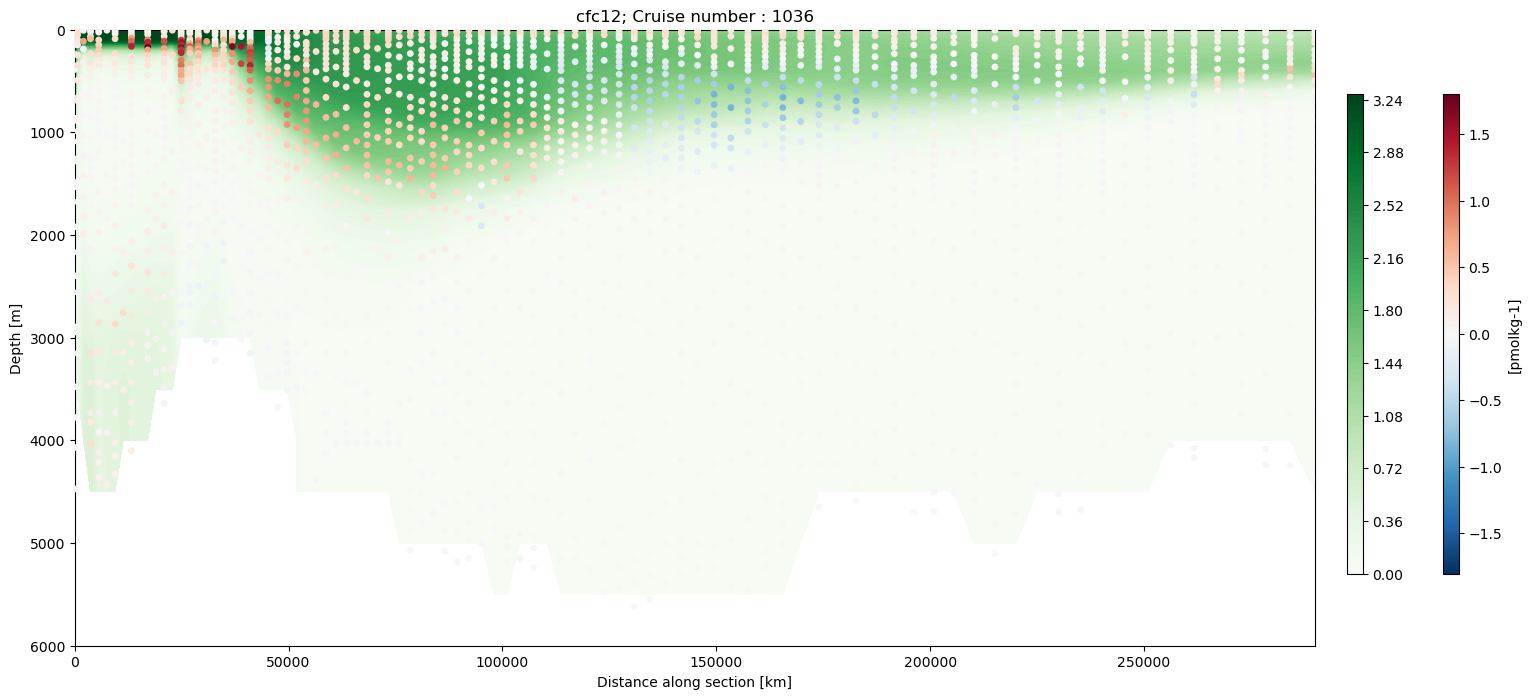

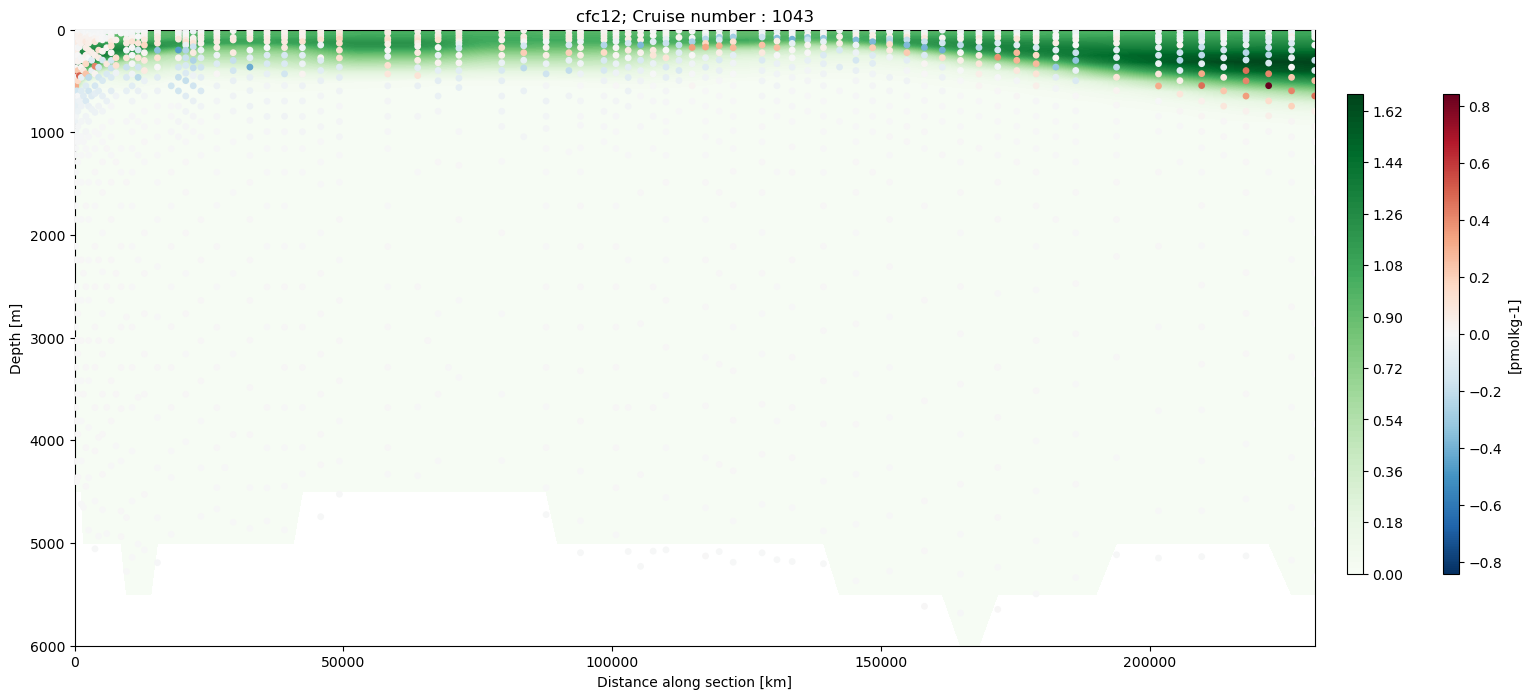

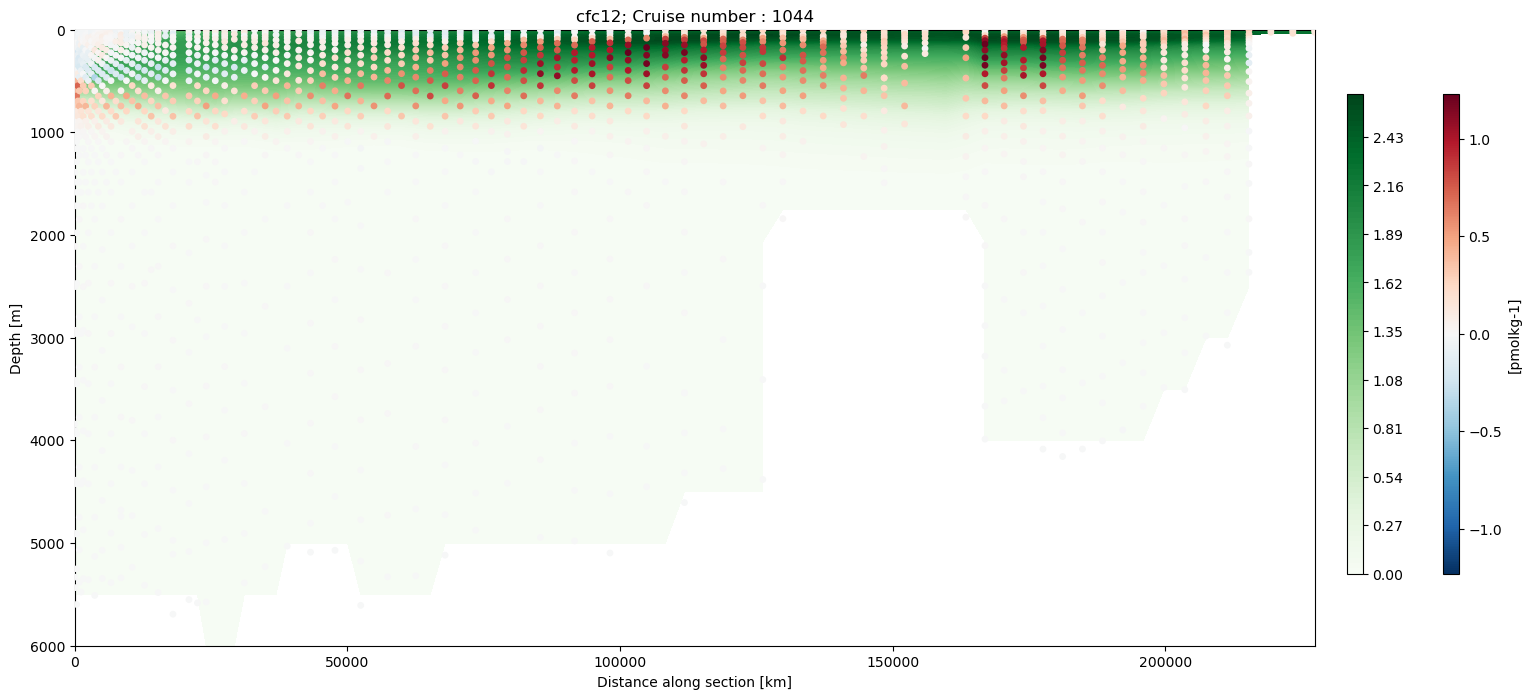

In [503]:
variable = 'cfc12'
cmap = variable_kwargs[variable]['cmap']
units = variable_kwargs[variable]['units']
for cruise in sections.keys():
    dsonow = sections[cruise]
    dsmnow = sections_dsm[cruise]
    dsmonow = sections_dsmo[cruise]
    bias = dsmonow - dsonow
    # Replace depth variable
    bias['depth'] = dsonow['depth']
    fig,ax = plt.subplots(figsize=(16,8))
    im1 = ax.contourf(dsmnow['distance'],dsmnow['z_l'],dsmnow[variable],100,cmap=cmap)
    # ax.contour(dsmnow['distance'],dsmnow['z_l'],dsmnow['theta'],14,colors='tab:purple',alpha=0.5)
    # ax.contour(dsmnow['distance'],dsmnow['z_l'],dsmnow['salinity'],14,colors='tab:brown',alpha=0.5)
    im2 = ax.scatter(bias['distance']*xr.ones_like(bias['depth']),bias['depth'],s=15,c=bias[variable],cmap='RdBu_r',zorder=10)
    clims_bias = im2.get_clim()
    cmax = np.max(np.abs(clims_bias))
    im2.set_clim([-1*cmax,cmax])
    ax.set_xlabel('Distance along section [km]')
    ax.set_ylabel('Depth [m]')
    ax.set_ylim([6000,0])
    ax.set_title(variable+'; Cruise number : '+str(cruise))
    # Add colorbars
    axc1 = fig.add_axes([0.92,0.2,0.01,0.6])
    cb = fig.colorbar(im1,axc1,orientation='vertical')
    axc2 = fig.add_axes([0.92+0.06,0.2,0.01,0.6])
    cb = fig.colorbar(im2,axc2,orientation='vertical')
    cb.set_label('['+units+']')

### T-S anomaly space

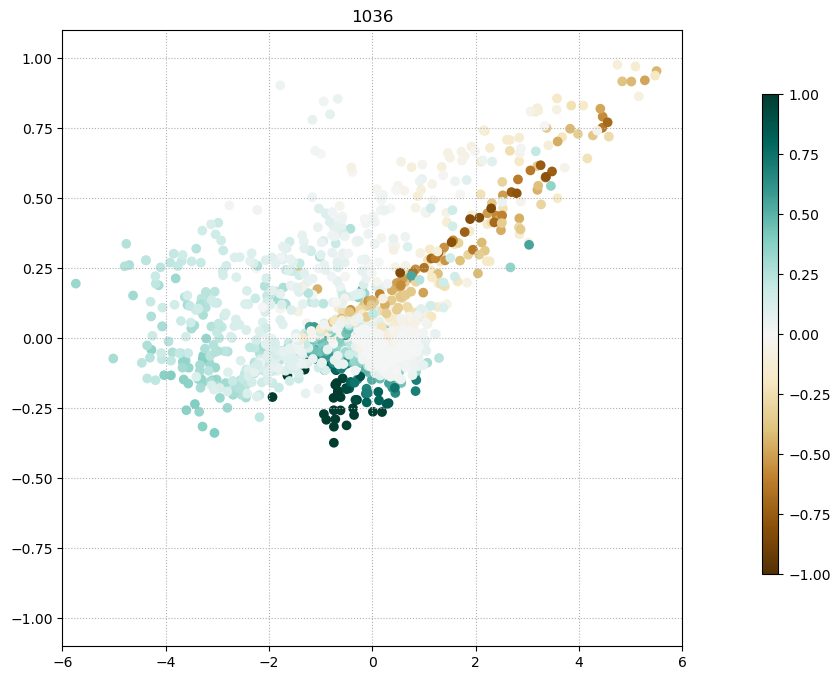

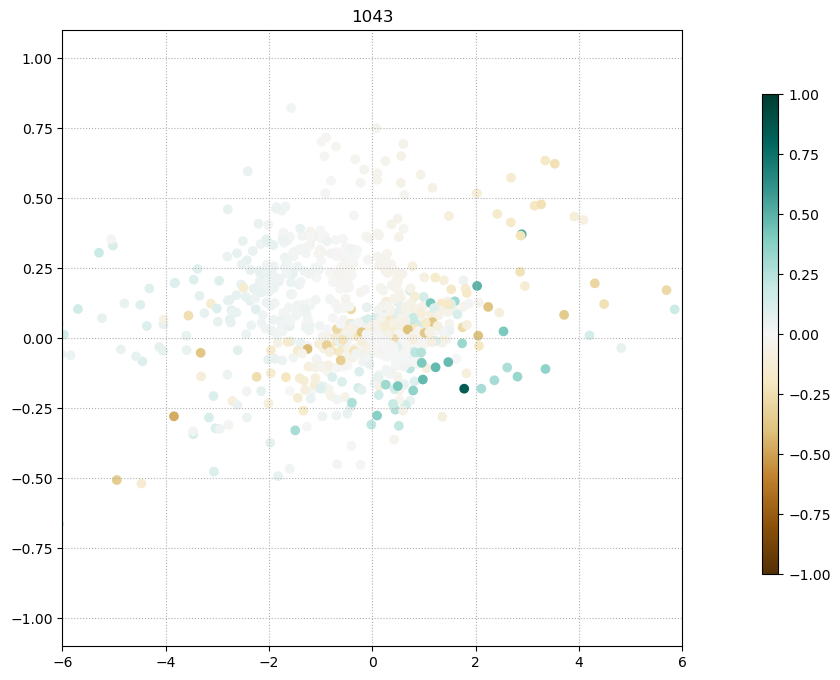

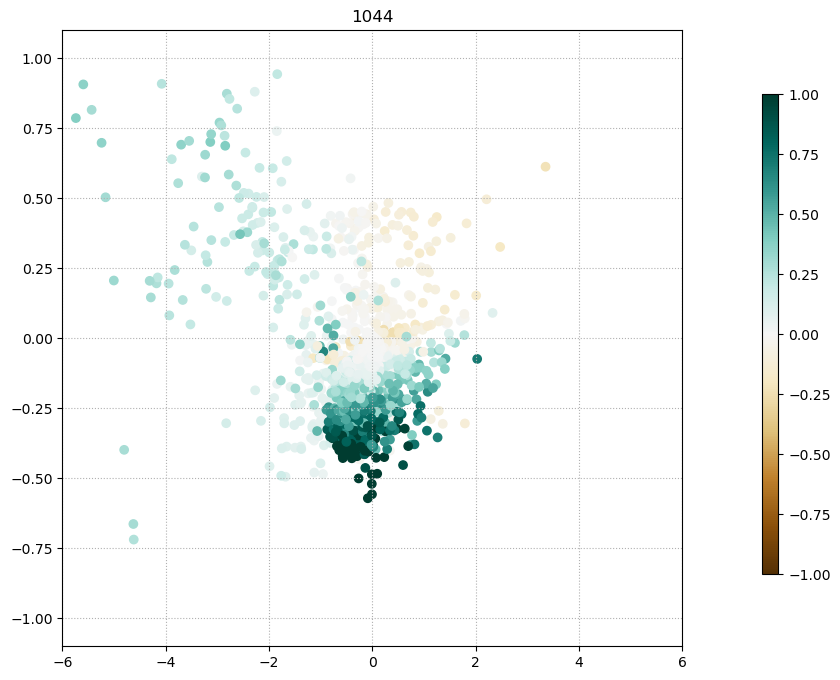

In [504]:
variable = 'cfc12'
for cruise,section in sections.items():
    bias = sections_dsmo[cruise]-section
    fig,ax = plt.subplots(figsize=(8,8))
    ax.grid(linestyle=':')
    im = ax.scatter(bias['theta'],bias['salinity'],c=bias[variable],cmap='BrBG',vmin=-1,vmax=1)
    ax.set_xlim([-6,6])
    ax.set_ylim([-1.1,1.1])
    ax.set_title(cruise)
    cax = fig.add_axes([1, 0.2, 0.02, 0.6])
    fig.colorbar(im, cax, orientation = 'vertical')

### T-S, groups and histograms

In [505]:
dsonow = sections[1036]
dsmonow = sections_dsmo[1036]
bias = dsmonow - dsonow

groupvar = 'theta'
anomaly = True

if anomaly:
    bins = variable_kwargs[groupvar]['anombins']
    dagroup = bias[groupvar]
else:
    bins = variable_kwargs[groupvar]['bins']
    dagroup = dsmonow[groupvar]

gs = {}
g = bias.groupby_bins(dagroup,bins,squeeze=False)
gs['mean'] = g.mean()
gs['std'] = g.std()
bin_centers = [i.mid for i in gs['mean'][groupvar+'_bins'].values]

hs = xr.Dataset()
hs['count'] = histogram(dagroup,bins=[bins],dim=['distance','n'],bin_dim_suffix='_bins')

In [506]:
variable = 'cfc12'

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


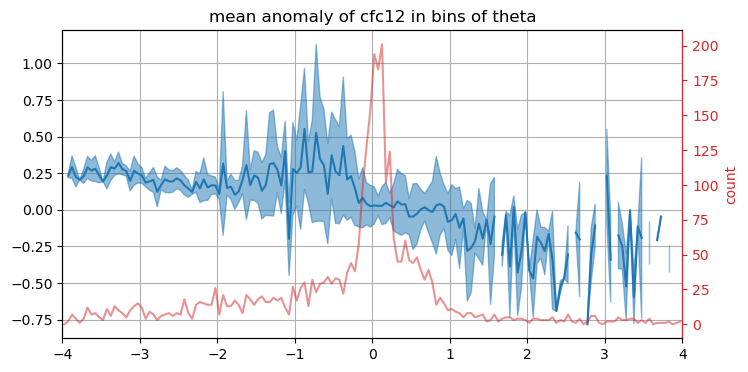

In [507]:
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(bin_centers,gs['mean'][variable],zorder=10)
ax.fill_between(bin_centers,gs['mean'][variable]-gs['std'][variable],gs['mean'][variable]+gs['std'][variable],color='tab:blue',alpha=0.5,zorder=9)
ax.set_xlim([np.min(bins),np.max(bins)])
ax.set_label(variable_kwargs[groupvar]['units'])
ax.grid()
ax.set_title('mean anomaly of '+variable+' in bins of '+groupvar)
axc = ax.twinx()
im = axc.plot(bin_centers,hs['count'],color='tab:red',alpha=0.5)
axc.set_ylabel('count')
axc.spines['right'].set_color('tab:red')
axc.yaxis.label.set_color('tab:red')
axc.tick_params(axis='y', colors='tab:red')

In [513]:
groupvar1 = 'theta'
groupvar2 = 'salinity'
anomaly = False

if anomaly:
    bins = [variable_kwargs[groupvar1]['anombins'],variable_kwargs[groupvar2]['anombins']]
    dagroup1 = bias[groupvar1]
    dagroup2 = bias[groupvar2]
else:
    bins = [variable_kwargs[groupvar1]['bins'],variable_kwargs[groupvar2]['bins']]
    dagroup1 = dsmonow[groupvar1]
    dagroup2 = dsmonow[groupvar2]

hs = xr.Dataset()
hs['count']=histogram(dagroup1,dagroup2,bins=bins,dim=['distance','n'])
for key,value in bias.items():
    if key=='depth':
        continue
    hs[key+'_sum']=histogram(dagroup1,dagroup2,bins=bins,dim=['distance','n'],weights=value)
    hs[key+'_mean']=hs[key+'_sum']/hs['count']

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


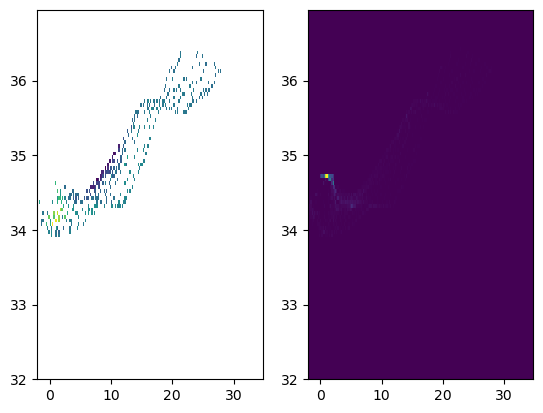

In [514]:
variable = 'cfc12'
fig,ax = plt.subplots(ncols=2)
ax[0].pcolormesh(hs['theta_bin'],hs['salinity_bin'],hs[variable+'_mean'].T,shading='auto')
ax[1].pcolormesh(hs['theta_bin'],hs['salinity_bin'],hs['count'].T,shading='auto')

***
# ARCHIVE

## Interpolate GLODAP data to Easy Ocean line
Options to use a 3D interpolator (`RBFInterpolator`; see [here](https://stackoverflow.com/questions/11214118/3d-extrapolation-in-python-basically-scipy-griddata-extended-to-extrapolate) for example) or the `LocStream` functionality in `xesmf.Regridder` (see [here](https://mom6-analysiscookbook.readthedocs.io/en/latest/notebooks/Comparing_to_section_data.html) for example).

In [186]:
from scipy.interpolate import RBFInterpolator

In [187]:
# Subset only to locations where measurements were made
cond = np.isfinite(dfo['G2cfc12'])
v = dfo[['G2longitude','G2latitude','G2depth']][cond].to_numpy()
d = dfo['G2cfc12'][cond].values

xi, yi, zi = np.meshgrid(dso_nc['longitude'].values,
                         dso_nc['latitude'].values,
                         dso_nc['pressure'].values)
vi = np.vstack((xi.ravel(), yi.ravel(), zi.ravel())).transpose()

rbf = RBFInterpolator(v, d, kernel="thin_plate_spline",smoothing=1000)
di = rbf(vi)

di = di.reshape(xi.shape)
tmp = dso_nc['temperature'].isel(gridded_section=0).squeeze()
dsg = xr.Dataset()
dsg['cfc12'] = tmp.copy(data=di.squeeze().transpose()).where(np.isfinite(tmp))

## Interpolate model data to Easy Ocean line

In [188]:
dsmo = dsm.interp({'lat':dso_nc['latitude'],'lon':dso_nc['longitude'],'z_l':dso_nc['pressure']}).squeeze()

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


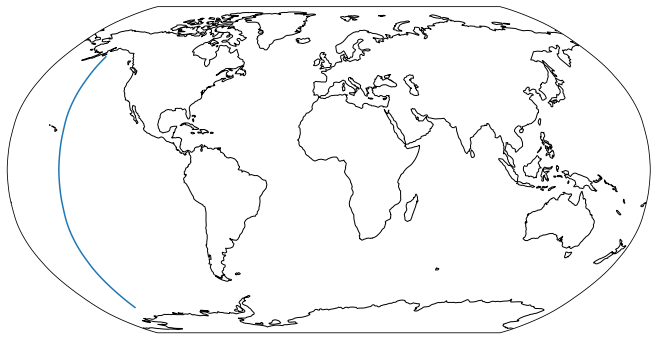

In [189]:
if dimx=='longitude':
    x=dso_nc['longitude'].values
    y=dso_nc['latitude']*xr.ones_like(dso_nc['longitude']).squeeze().values
elif dimx=='latitude':
    x=dso_nc['longitude']*xr.ones_like(dso_nc['latitude']).squeeze().values
    y=dso_nc['latitude'].values
    
fig,ax=plt.subplots(figsize=(12,6),subplot_kw={'projection':ccrs.Robinson()})
ax.set_global()
ax.plot(x,y,transform=ccrs.PlateCarree())
ax.coastlines()

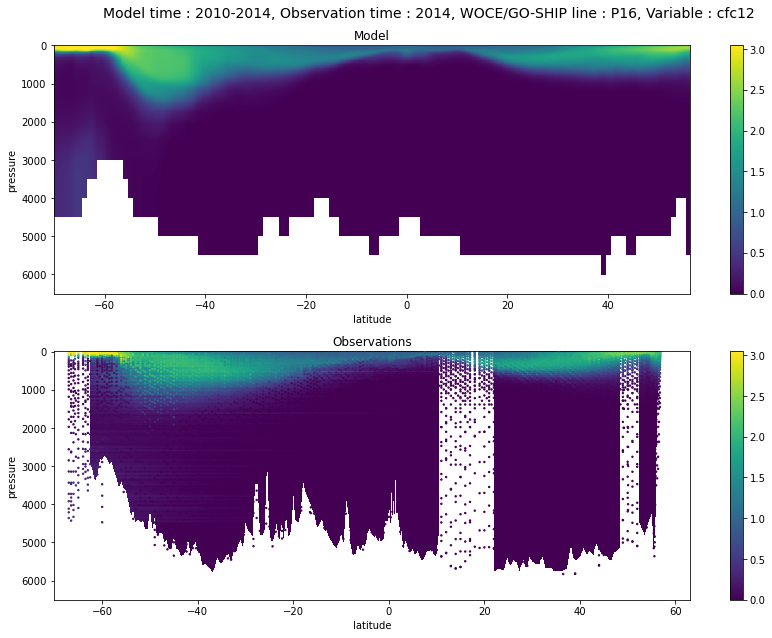

In [196]:
variable = 'cfc12'
conversion = 1e12/1035
x = dsg[dimx]
y = dsg['pressure']
zo = dsg[variable]
zm = dsmo[variable]*conversion

fig,ax = plt.subplots(figsize=(12,9),nrows=2)

fig.suptitle('Model time : '+time+
              ', Observation time : '+str(yearo)+
              ', WOCE/GO-SHIP line : '+line+
              ', Variable : '+variable,
            fontsize=14)

im = ax[0].pcolormesh(x,y,zm,shading='auto')
ax[0].invert_yaxis()
ax[0].set_title('Model')
ax[0].set_xlabel(dimx)
ax[0].set_ylabel('pressure')
plt.colorbar(im,ax=ax[0])

imp = ax[1].pcolormesh(x,y,zo,shading='auto')
ax[1].invert_yaxis()
# Add original observations
ims = ax[1].scatter(v[:,1],v[:,2],c=d,s=2)
clims = list(imp.get_clim())
clims[0]=0
imp.set_clim(clims)
ims.set_clim(clims)
im.set_clim(clims) # Set model lims to obs
ax[1].set_title('Observations')
ax[1].set_xlabel(dimx)
ax[1].set_ylabel('pressure')
plt.colorbar(imp,ax=ax[1])

fig.tight_layout()